![](https://wallup.net/wp-content/uploads/2016/01/19116-Eastern_Imperial_Eagle-nature-animals-birds-eagle.jpg)

# BirdCLEF 2022 : Model Building and Training
---

In this notebook we will make the Neural Network model and train it on the data itself.

**This is the second of the 3 notebooks which improvises from the findings of the first notebook and prepare the appropriate model and dataset and train the model on it.**

# Installations

In [1]:
!pip install torchsummary

# Libraries

In [2]:
# General purpose libraries for loading and manipulating data
import os
import re
import json
import time
import numpy as np
import pandas as pd
from glob import glob


# Pytorch imports for neural networks and tensor manipulations
import torch
import torchaudio
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram
from torch.utils.data import Dataset, DataLoader, random_split


# Libraries for visualization
import torchsummary
from termcolor import cprint
import matplotlib.pyplot as plt


# Libraries to hide warnings
import warnings
warnings.filterwarnings("ignore")


# ipywidgets
%matplotlib inline

# Datapaths

In [3]:
train_base_path = "../input/birdclef-2022/train_metadata.csv"
test_base_path = "../input/birdclef-2022/test.csv"
sample_submission_base_path = "../input/birdclef-2022/sample_submission.csv"
bird_taxonomy_base_path = "../input/birdclef-2022/eBird_Taxonomy_v2021.csv"
labels_base_path = "../input/birdclef-2022/scored_birds.json"
train_dir = "../input/birdclef-2022/train_audio"
test_dir = "../input/birdclef-2022/test_soundscapes"

### Loading train metadata

In [4]:
train_df = pd.read_csv(train_base_path)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


# Processing
Now we have to process training data so that it would be helpful for us.

In [5]:
imp_features = ["primary_label", "type", "rating", "filename"]
train_df = train_df[imp_features]
train_df.head()

,primary_label,type,rating,filename
0,afrsil1,"['call', 'flight call']",2.5,afrsil1/XC125458.ogg
1,afrsil1,['call'],3.5,afrsil1/XC175522.ogg
2,afrsil1,"['call', 'song']",4.0,afrsil1/XC177993.ogg
3,afrsil1,"['alarm call', 'call']",4.0,afrsil1/XC205893.ogg
4,afrsil1,['flight call'],3.0,afrsil1/XC207431.ogg


In this scenario we are only taking the calls which only resemble a proper call not some specific or unique call , cause those will destroy the patterns.

In [6]:
def extract_call(data, call = 'call'):
    try:
        if re.search(data, call):
            return "True"
        else:
            return "False"
    except:
        return "False"

In [7]:
print("Length of data before call extraction : {}".format(len(train_df)))
train_df["type"] = train_df["type"].apply(extract_call)
train_df = train_df[train_df["type"] == "True"]
train_df.drop("type", 1, inplace = True)
print("Length of data after call extraction : {}".format(len(train_df)))
train_df.head()

Length of data before call extraction : 14852
Length of data after call extraction : 12773


,primary_label,rating,filename
0,afrsil1,2.5,afrsil1/XC125458.ogg
1,afrsil1,3.5,afrsil1/XC175522.ogg
2,afrsil1,4.0,afrsil1/XC177993.ogg
3,afrsil1,4.0,afrsil1/XC205893.ogg
4,afrsil1,3.0,afrsil1/XC207431.ogg


Creating a class encoding dictionary which will help us find the correct class names in future.

In [8]:
class_dict = dict()

for index, label in enumerate(train_df.primary_label.unique()):
    class_dict[index] = label
    train_df["primary_label"].replace(label, index, inplace = True)
print(class_dict)

{0: 'afrsil1', 1: 'akekee', 2: 'akepa1', 3: 'akiapo', 4: 'akikik', 5: 'amewig', 6: 'aniani', 7: 'apapan', 8: 'arcter', 9: 'barpet', 10: 'bcnher', 11: 'belkin1', 12: 'bkbplo', 13: 'bknsti', 14: 'bkwpet', 15: 'blkfra', 16: 'blknod', 17: 'bongul', 18: 'brant', 19: 'brnboo', 20: 'brnnod', 21: 'brnowl', 22: 'brtcur', 23: 'bubsan', 24: 'buffle', 25: 'bulpet', 26: 'burpar', 27: 'buwtea', 28: 'cacgoo1', 29: 'calqua', 30: 'cangoo', 31: 'canvas', 32: 'caster1', 33: 'categr', 34: 'chbsan', 35: 'chemun', 36: 'chukar', 37: 'cintea', 38: 'comgal1', 39: 'commyn', 40: 'compea', 41: 'comsan', 42: 'comwax', 43: 'coopet', 44: 'crehon', 45: 'dunlin', 46: 'elepai', 47: 'ercfra', 48: 'eurwig', 49: 'fragul', 50: 'gadwal', 51: 'gamqua', 52: 'glwgul', 53: 'gnwtea', 54: 'golphe', 55: 'grbher3', 56: 'grefri', 57: 'gresca', 58: 'gryfra', 59: 'gwfgoo', 60: 'hawama', 61: 'hawcoo', 62: 'hawcre', 63: 'hawgoo', 64: 'hawhaw', 65: 'hawpet1', 66: 'hoomer', 67: 'houfin', 68: 'houspa', 69: 'hudgod', 70: 'iiwi', 71: 'incter

Saving the object in a file so that we can use it on further cases.

In [9]:
json.dump(class_dict, open("class_dict.json", "w"))

Let's check the processed training metadata.

In [10]:
train_df.head()

,primary_label,rating,filename
0,0,2.5,afrsil1/XC125458.ogg
1,0,3.5,afrsil1/XC175522.ogg
2,0,4.0,afrsil1/XC177993.ogg
3,0,4.0,afrsil1/XC205893.ogg
4,0,3.0,afrsil1/XC207431.ogg


Similarly saving this for using in custom dataset and for future.

In [11]:
train_df.to_csv("training_metadata.csv", index = False)

# Dataset

The first task is to fix the random seed i.e. we can replicate all the next scenarios. also setting the audio backend to lod the audio data into tensors.

In [12]:

torch.manual_seed(42)
torchaudio.set_audio_backend("soundfile")

Now , it's time to build our custom dataset which will take the data directory and the processed training metadata and create trainable data.

In [13]:
class CLEFDataset(Dataset):
    
    def __init__(self,
                 data_dir,
                 metadata_path,
                 size = 640,
                 transform = None):
        super(CLEFDataset, self).__init__()
        self.data_dir = data_dir
        self.metadata = pd.read_csv(metadata_path)
        self.size = size
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        path = self.metadata.loc[index, "filename"]
        path = os.path.join(self.data_dir, path)
        label = self.metadata.loc[index, "primary_label"]
        mono_audio = self.load_audio(path)
        mono_audio = mono_audio.unsqueeze(dim=0)
        return mono_audio, label
    
    
    def load_audio(self, path):
        audio, _ = torchaudio.load(path)
        if self.transform != None:
            for aug in self.transform:
                audio = aug(audio)
        return audio[0,:]

We also need a bit of data equivalence, so that training can be more specific.

In [14]:
augm = [
    MelSpectrogram(n_mels = 128),
    Resize((128, 128))
]
augm

[MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 ),
 Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)]

Now creating the dataset

In [15]:
metadata_path = "./training_metadata.csv"
dataset = CLEFDataset(train_dir, metadata_path, transform = augm)

In [16]:
len(dataset)

12773

In [17]:
data, label = dataset[10]
print("Audio Shape : {} , label : {}".format(data.shape, label))

Audio Shape : torch.Size([1, 128, 128]) , label : 0


The dataset is created correctly.
Now we should split the dataset into training and validation sets.

**Train-Validation Ratio = 4:1**

In [18]:
x1 = int(len(dataset) * 0.8)
x2 = len(dataset) - x1
train_ds, val_ds = random_split(dataset, [x1, x2])

In [19]:
print("Length of Training Dataset : {}".format(len(train_ds)))
print("Length of Validation Dataset : {}".format(len(val_ds)))

Length of Training Dataset : 10218
Length of Validation Dataset : 2555


Now it's time to create patch of data which will be a better way to train the model as it won't need too much space to load the whole data but patches of it. 
Note : The datasets are shuffled so that sparsity stays present.

In [20]:
BATCH_SIZE = 64

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = True)

Let's check the data chunks

In [21]:
for patch, labels in train_dl:
    print(patch.shape, labels.shape)
    break
for patch, labels in val_dl:
    print(patch.shape, labels.shape)
    break

torch.Size([64, 1, 128, 128]) torch.Size([64])
torch.Size([64, 1, 128, 128]) torch.Size([64])


# Neural Network Model

In here we have used several CNN and ANN layers just to be sure we do not leave any crucial data.

In [22]:
# Convolution shape updating function
def conv_shape(shape, kernel_size, stride, padding):
    H, W = shape[0], shape[1]
    H = ((H - kernel_size + 2*padding) // stride) + 1
    W = ((W - kernel_size + 2*padding) // stride) + 1
    return H, W

In [23]:
class Conv(nn.Module):
    
    def __init__(self, 
                   in_channels,
                   out_channels,
                   kernel_size,
                   stride=(1,1),
                   padding=(0,0),
                   momentum=0.15):
        super(Conv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels, momentum = momentum),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.conv_block(x)


class CLEFNetwork(nn.Module):
    
    def __init__(self,
                 num_classes,
                 in_channels = 1,
                 H = 128,
                 W = 128,
                 num_downs = 3):
        super(CLEFNetwork, self).__init__()
        
        self.num_C = num_classes
        self.num_downs = num_downs
        self.in_channels = in_channels
        self.C = 8
        self.H, self.W = self.calc_HW(H, W)
        self.in_conv_block = Conv(self.in_channels, self.C, 7, (2, 2))
        self.conv_block = nn.ModuleList(
                [
                    Conv(self.C * 2**i, self.C * 2**(i+1), 3, (2, 2))
                    for i in range(self.num_downs-1)
                ]
        )
        self.fc_block = nn.Sequential(
                nn.Linear(self.H * self.W * self.C * 2**(self.num_downs - 1), 1024),
                nn.Linear(1024, 1024),
                nn.Linear(1024, self.num_C)
        )
        
    def calc_HW(self, H, W):
        H, W = conv_shape((H, W), 7, 2, 0)
        for num_down in range(self.num_downs - 1):
            H, W = conv_shape((H, W), 3, 2, 0)
        return H, W
        
        
    def forward(self, x):
        x = self.in_conv_block(x)
        for block in self.conv_block:
            x = block(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_block(x)
        return x

Now loading the class label dictionary which contains the tital number of classes.

In [24]:
class_labels_path = "./class_dict.json"

In [25]:
class_labels = json.load(open(class_labels_path, "r"))
num_classes = len(class_labels.keys())
print("Number of class : {}".format(num_classes))

Number of class : 152


Let's try a simple forward pass with some random data on the model.

In [26]:
model = CLEFNetwork(num_classes)
rand_data = torch.rand(5, 1, 128, 128)
model(rand_data).shape

torch.Size([5, 152])

Before starting the training , let's check whether all the layers are passing through the model parameters, otherwise they won't be updated with the gradients on backtracking.

In [27]:
for name, param in model.named_parameters():
  print(f"{name} : {param.shape}, requires_grad : {param.requires_grad}")

in_conv_block.conv_block.0.weight : torch.Size([1]), requires_grad : True
in_conv_block.conv_block.0.bias : torch.Size([1]), requires_grad : True
in_conv_block.conv_block.1.weight : torch.Size([8, 1, 7, 7]), requires_grad : True
in_conv_block.conv_block.1.bias : torch.Size([8]), requires_grad : True
conv_block.0.conv_block.0.weight : torch.Size([8]), requires_grad : True
conv_block.0.conv_block.0.bias : torch.Size([8]), requires_grad : True
conv_block.0.conv_block.1.weight : torch.Size([16, 8, 3, 3]), requires_grad : True
conv_block.0.conv_block.1.bias : torch.Size([16]), requires_grad : True
conv_block.1.conv_block.0.weight : torch.Size([16]), requires_grad : True
conv_block.1.conv_block.0.bias : torch.Size([16]), requires_grad : True
conv_block.1.conv_block.1.weight : torch.Size([32, 16, 3, 3]), requires_grad : True
conv_block.1.conv_block.1.bias : torch.Size([32]), requires_grad : True
fc_block.0.weight : torch.Size([1024, 6272]), requires_grad : True
fc_block.0.bias : torch.Size([1

All looks fine. Let's visualize the model

In [28]:

torchsummary.summary(model, (1, 128, 128), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 128, 128]               2
            Conv2d-2            [-1, 8, 61, 61]             400
              ReLU-3            [-1, 8, 61, 61]               0
              Conv-4            [-1, 8, 61, 61]               0
       BatchNorm2d-5            [-1, 8, 61, 61]              16
            Conv2d-6           [-1, 16, 30, 30]           1,168
              ReLU-7           [-1, 16, 30, 30]               0
              Conv-8           [-1, 16, 30, 30]               0
       BatchNorm2d-9           [-1, 16, 30, 30]              32
           Conv2d-10           [-1, 32, 14, 14]           4,640
             ReLU-11           [-1, 32, 14, 14]               0
             Conv-12           [-1, 32, 14, 14]               0
           Linear-13                 [-1, 1024]       6,423,552
           Linear-14                 [-

We need an accuracy counting function for training purpose.

In [29]:
def accuracy_func(pred, true):
    pred = torch.argmax(pred, dim = 1)
    acc = sum(true == pred)
    return acc

# Model training and saving best models

The first task in these phase is to set the hyperparameters.

Also we need to check whether any distributive device (**GPU** , **TPU**) is present or not as it may be efficient for model training.

In [30]:
EPOCHS = 10
optim = Adam(model.parameters(), lr = 1e-4)
criterion = CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Training:

Now it is the most important moment of the whole task.

The training loop will take the best model on the accuracy and loss metrics.

In [31]:
train_init = time.time()
cprint("Started training...", "blue")
best_loss = np.inf
best_acc = 0.0
if device == "cuda:0":
    print("Model Loaded on GPU...")
    model = model.cuda()
update = 0
TL, VL, TA, VA = [], [], [], []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} :")
    epoch_init = time.time()
    train_loss = val_loss = 0.0
    train_acc = val_acc = 0
    tot_val_data_point = 0
    model.train()
    for train_index, (patch, labels) in enumerate(train_dl):
        optim.zero_grad()
        if device == "cuda:0":
            dev_patch = patch.cuda()
            dev_labels = labels.cuda()
        else:
            dev_patch = patch
            dev_labels = labels
        output = model(dev_patch)
        acc = accuracy_func(output, dev_labels)
        train_acc += acc
        loss = criterion(output, dev_labels)
        train_loss += loss.item()
        TL.append(loss.item())
        TA.append(acc / dev_patch.shape[0])
        if train_index % 10 == 9:
            print(f"      [Step {train_index + 1}] Loss : {'%.6f'%loss.item()}")
        loss.backward()
        optim.step()
        
    model.eval()
    with torch.no_grad():
        for val_index, (patch, labels) in enumerate(val_dl):
            if device == "cuda:0":
                dev_patch = patch.cuda()
                dev_labels = labels.cuda()
            else:
              dev_patch = patch
              dev_labels = labels
            output = model(dev_patch)
            acc = accuracy_func(output, dev_labels)
            val_acc += acc
            loss = criterion(output, dev_labels)
            val_loss += loss.item()
            VL.append(loss.item())
            VA.append(acc / dev_patch.shape[0])
    TRAIN_ACC = train_acc / len(train_ds)
    VAL_ACC = val_acc / len(val_ds)
    print(f"   Train Loss : {'%.6f'%train_loss} | Train accuracy : {'%.6f'%TRAIN_ACC}")
    print(f"   Validation Loss : {'%.6f'%val_loss} | Validation Accuracy : {'%.6f'%VAL_ACC}")
    updation_flag = False
    if val_loss < best_loss:
      update = 0
      updation_flag = True
      best_loss = val_loss
      cprint("Loss Updation : Positive", "green")
      torch.save({
          "model" : model.state_dict(),
          "optim" : optim.state_dict(),
          "epoch" : epoch + 1
      }, "best_loss_model.pt")
    if VAL_ACC > best_acc:
      update = 0
      updation_flag = True
      best_acc = VAL_ACC
      cprint("Accuracy Updation : Positive", "green")
      torch.save({
          "model" : model.state_dict(),
          "optim" : optim.state_dict(),
          "epoch" : epoch + 1
      }, "best_accuracy_model.pt")
    if updation_flag == False:
        cprint("Model Updation : Negative\n", "red")
        update += 1
    print(f"   Execution Time : {'%.3f'%(time.time() - epoch_init)} seconds\n")
    if update >= 5:
      cprint("Model Stopped due to continuous model learning degradation\n", "red")
      break
cprint("Training finished...", "blue")
cprint(f"Exceution Time : {'%.3f'%(time.time() - train_init)} seconds", "blue")

Started training...
Model Loaded on GPU...
Epoch 1 :
      [Step 10] Loss : 4.818160
      [Step 20] Loss : 4.583258
      [Step 30] Loss : 4.389036
      [Step 40] Loss : 3.980569
      [Step 50] Loss : 4.243809
      [Step 60] Loss : 4.216794
      [Step 70] Loss : 4.121332
      [Step 80] Loss : 4.277384
      [Step 90] Loss : 4.263050
      [Step 100] Loss : 3.929511
      [Step 110] Loss : 4.155273
      [Step 120] Loss : 4.431555
      [Step 130] Loss : 4.255734
      [Step 140] Loss : 4.092558
      [Step 150] Loss : 4.111647
      [Step 160] Loss : 4.179440
   Train Loss : 690.737953 | Train accuracy : 0.070464
   Validation Loss : 163.601886 | Validation Accuracy : 0.094716
Loss Updation : Positive
Accuracy Updation : Positive
   Execution Time : 1700.411 seconds

Epoch 2 :
      [Step 10] Loss : 3.883323
      [Step 20] Loss : 3.687260
      [Step 30] Loss : 3.999615
      [Step 40] Loss : 3.846511
      [Step 50] Loss : 3.689812
      [Step 60] Loss : 3.755176
      [Step 70

# Visualization: 

Now that the training has been completed, we can plot the loss and accuracy curves to see the model performances.

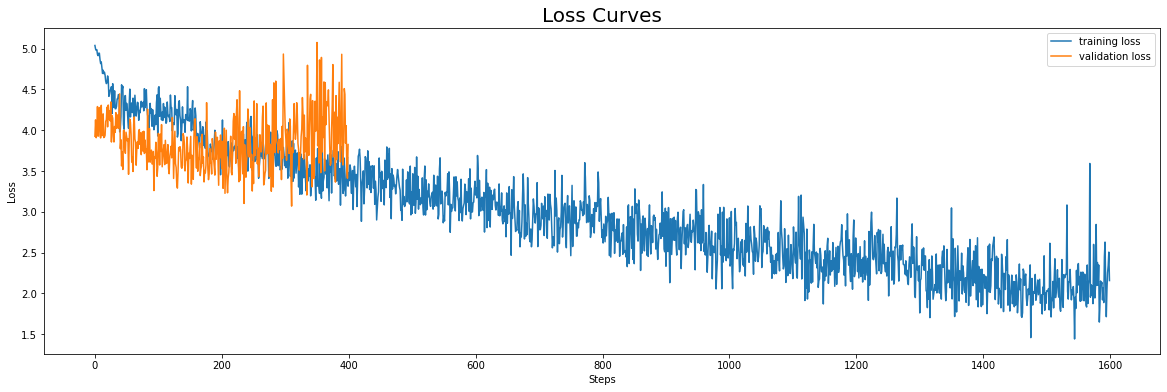

In [32]:
plt.figure(figsize = (20, 6))
plt.plot(TL, label = "training loss")
plt.plot(VL, label = "validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curves", size = 20)
plt.legend()
plt.show()

The accuracies are stored as GPU tensors , so we have make them ordinary float variables for plotting.

In [33]:
for index in range(len(TA)):
    TA[index] = float(TA[index].cpu().detach())
for index in range(len(VA)):
    VA[index] = float(VA[index].cpu().detach())

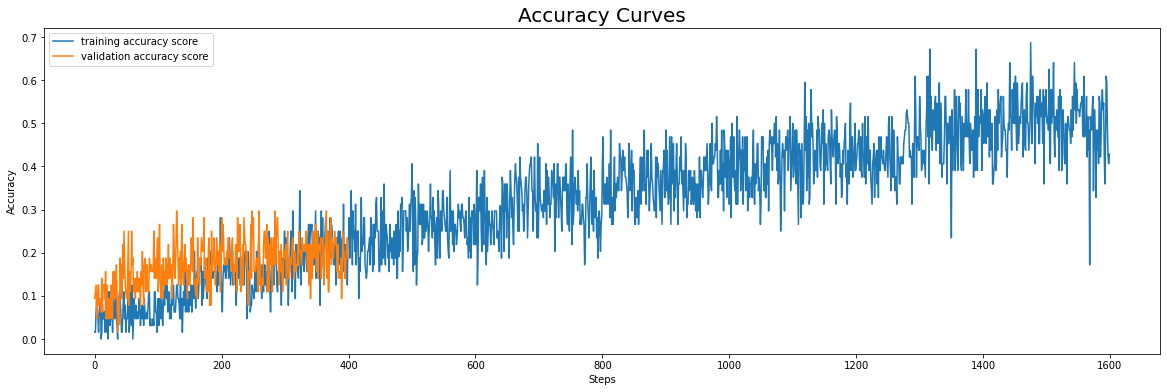

In [34]:
plt.figure(figsize = (20, 6))
plt.plot(TA, label = "training accuracy score")
plt.plot(VA, label = "validation accuracy score")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves", size = 20)
plt.legend()
plt.show()

# Thanks for visiting :)

# Do UPVOTE if you like the notebook :)
## Also follow me on [kaggle](https://www.kaggle.com/sagnik1511) , [GitHub](https://github.com/sagnik1511) and on [LinkedIn](https://www.linkedin.com/in/sagnik1511)